# CS5489 - Machine Learning
# Lecture 9b - Regularization
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
- Convolutional neural network (CNN)
- **Regularization**

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from scipy import signal

rbow = plt.get_cmap('rainbow')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout
from tensorflow.keras import backend as K
import struct
print(keras.__version__, tf.__version__)

# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')

2.4.0 2.4.1


In [3]:
def plot_history(history, showacc=True): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if showacc and ('accuracy' in history.history):
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [4]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                plt.title(titles % idx)
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()


In [5]:
def read_32int(f):
    return struct.unpack('>I', f.read(4))[0]
def read_img(img_path):
    with open(img_path, 'rb') as f:
        magic_num = read_32int(f)
        num_image = read_32int(f)
        n_row = read_32int(f)
        n_col = read_32int(f)
        #print 'num_image = {}; n_row = {}; n_col = {}'.format(num_image, n_row, n_col)
        res = []
        npixel = n_row * n_col
        res_arr = fromfile(f, dtype='B')
        res_arr = res_arr.reshape((num_image, n_row, n_col), order='C')
        #print 'image data shape = {}'.format(res_arr.shape)
        return num_image, n_row, n_col, res_arr    
def read_label(label_path):
    with open(label_path, 'rb') as f:
        magic_num = read_32int(f)
        num_label = read_32int(f)
        #print 'num_label = {}'.format(num_label)
        res_arr = fromfile(f, dtype='B')
        #print res_arr.shape
        #res_arr = res_arr.reshape((num_label, 1))
        res_arr = res_arr.ravel()
        #print 'label data shape = {}'.format(res_arr.shape)
        return num_label, res_arr

In [6]:
n_train, nrow, ncol, trainimg = read_img('data/train-images.idx3-ubyte')
_, trainY = read_label('data/train-labels.idx1-ubyte')
n_test, _, _, testimg = read_img('data/t10k-images.idx3-ubyte')
_, testY = read_label('data/t10k-labels.idx1-ubyte')

# for demonstration we only use 10% of the training data
sample_index = range(0, trainimg.shape[0], 10)
trainimg  = trainimg[sample_index]
trainY    = trainY[sample_index]
print(trainimg.shape)
print(trainY.shape)
print(testimg.shape)
print(testY.shape)

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)

(6000, 28, 28)
(6000,)
(10000, 28, 28)
(10000,)


In [7]:
# scale to 0-1
trainI = (trainimg.reshape((6000,28,28,1)) / 255.0)
testI  = (testimg.reshape((10000,28,28,1)) / 255.0)
print(trainI.shape)
print(testI.shape)

(6000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4487)

validsetI = (validI, validYb)

# Regularization with L2-norm
- One way regularize the network is to add an L2-norm penalty on the weights
  - Add a penalty term to the loss function
    - larger weights have higher penalty
    - $\hat{L} = L + \lambda\frac{1}{2}||\mathbf{w}||^2$

- Taking the gradient of $\hat{L}$,
  - $\frac{d\hat{L}}{d\mathbf{w}} = \frac{dL}{d\mathbf{w}} + \lambda \mathbf{w}$
- Applying gradient descent
  - $\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{d\hat{L}}{d\mathbf{w}}$
  - $\mathbf{w} \leftarrow \mathbf{w} - \eta (\frac{dL}{d\mathbf{w}} + \lambda \mathbf{w})$
  - $\mathbf{w} \leftarrow (1-\eta\lambda)\mathbf{w} - \eta \frac{dL}{d\mathbf{w}}$
- the weights shrink by $(1-\eta\lambda)$ in each iteration of gradient descent.
  - prevents the $\mathbf{w}$ from getting too large.
  - Sometimes this is called **weight-decay** regularization.
    

- The optimal solution is an equilibrium point between L2-norm (dashed-line) and the loss (solid-line).
  - $\lambda\mathbf{w} = -\frac{dL}{d\mathbf{w}}$.
<center><img src="imgs/weightdecay.png" width=300></center>

# Example: L2 regularization
- Apply L2 regularization on all layers.
  - `kernel_regularizer` keyword

In [9]:
K.clear_session()  # cleanup
# initialize random seed
random.seed(4487); tf.random.set_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu',
              input_shape=(28,28,1),
              kernel_regularizer=keras.regularizers.l2(0.0001),  # L2 regularizer
              padding='same'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu',
              kernel_regularizer=keras.regularizers.l2(0.0001),  # L2 regularizer
              padding='same'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu',
              kernel_regularizer=keras.regularizers.l2(0.0001),  # L2 regularizer
              padding='same'))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu', 
             kernel_regularizer=keras.regularizers.l2(0.0001))) # L2 regularizer
nn.add(Dense(units=10, activation='softmax', 
       kernel_regularizer=keras.regularizers.l2(0.0001)))        # L2 regularizer

# setup early stopping callback function
earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto'
)
callbacks_list = [earlystop]
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00010: early stopping


test accuracy: 0.9664


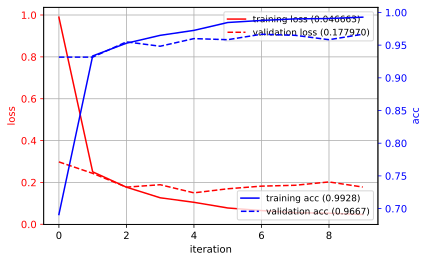

In [10]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Which layers should we apply L2 regularization?
- Consider the following network: $f(\mathbf{x}) = \mathbf{A}^T r( \mathbf{B}^T \mathbf{x})$
   - $r(\cdot)$ is the ReLU activation.
- Consider the scaling value $\epsilon>0$:
  $$f(\mathbf{x}) = \mathbf{A}^T r( \mathbf{B}^T \mathbf{x}) = \mathbf{A}^T r( \frac{\epsilon}{\epsilon}\mathbf{B}^T \mathbf{x}) = \frac{1}{\epsilon}\mathbf{A}^T r( \epsilon\mathbf{B}^T \mathbf{x})$$
  - the last line is because for $b>0$, $r(b a) = \max(0,b a) = b \max(0,a)$


- If we decrease $\mathbf{B}$ by $\epsilon<1$, we can increase $\mathbf{A}$ correspondingly to create the same network (with the same loss $L$).
  - Thus, when applying L2 regularization on only one layer, the other layer can be adjusted to get the same network.
  - The L2-norm is artificially reduced without changing the network function.

- **Answer**: apply L2 regularization to *all* layers!

# Overfitting
- occurs when validiation curve starts to increase
  - network is specializing only on  the training data, losing generalization ability.

In [11]:
K.clear_session()  # cleanup
# initialize random seed
random.seed(4487); tf.random.set_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), 
              activation='relu', input_shape=(28,28,1),
              padding='same'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu',
              padding='same'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu',
              padding='same'))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 validation_data=validsetI, verbose=False)



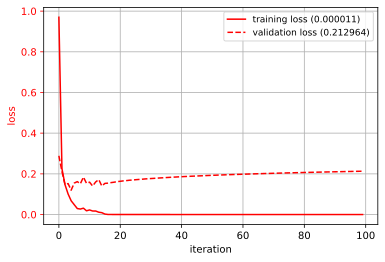

In [12]:
plot_history(history, showacc=False)

# Early Stopping
- Stopping training when the validation loss increases
  - equivalently, selecting the model/iteration with lowest validation loss.

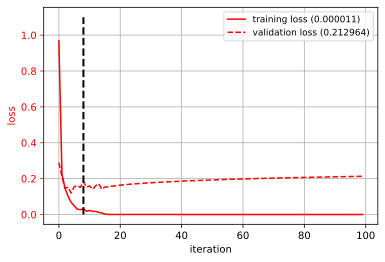

In [13]:
plot_history(history, showacc=False)
plt.plot([8,8], [0,1.1], 'k--', lw=2);

# Early Stopping as Regularization
- Early stopping is a form of regularization
  - limit the number of training iterations = limiting how far parameters $\mathbf{w}$ can move.
    - e.g., if we initialize $\mathbf{w}=0$, then early stopping limits the L2-norm of $\mathbf{w}$.
  - the amount $\mathbf{w}$ can move is adaptive to the data via the validation loss.
  
<center><img src="imgs/earlystop.png" width=400></center>

# Improving Generalization with Ensembles
- **Bagging**: Bootstrap Aggregation
  - combine predictions from several models (model averaging).
- Suppose we have $K$ models, each model has error $\epsilon_i$
  - MSE of each model: $\mathrm{MSE}_i = \mathbb{E}[\epsilon_i^2] = V$
- Combining the models:
  - MSE of the combined model: $\mathrm{MSE}_c = \frac{V}{K} + \frac{K-1}{K} C$
    - $C=\mathbb{E}[\epsilon_i \epsilon_j]$ is the correlation between errors of the i-th and j-th models.
- If the errors are uncorrelated ($C=0$), then the MSE decreases!
  - $\mathrm{MSE}_c = \frac{V}{K}$

# Bagging for NN
- Typically bagging needs to create a new dataset by sampling with replacement of the original dataset, and then learning a new model on each generated dataset.
- For NN, there are enough solution points
  - we can use the same dataset, and different initializations (or change hyperparameters).
  - this should give models with partially uncorrelated errors.
- This is a **very** popular way to boost performance.

In [14]:
K.clear_session()  # cleanup
random.seed(4487); tf.random.set_seed(4487) # initialize random seed


allnn = []
allhistory = []
for bag in range(5):
    # build the network
    nn = Sequential()
    nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu',
                  input_shape=(28,28,1),
                  kernel_regularizer=keras.regularizers.l2(0.0001),  # L2 regularizer
                  padding='same'))
    nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.0001),  # L2 regularizer
                  padding='same'))
    nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.0001),  # L2 regularizer
                  padding='same'))
    nn.add(Flatten())
    nn.add(Dense(units=50, activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(0.0001))) # L2 regularizer
    nn.add(Dense(units=10, activation='softmax', 
           kernel_regularizer=keras.regularizers.l2(0.0001)))        # L2 regularizer

    # compile and fit the network
    nn.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])
    history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                     callbacks=callbacks_list, 
                     validation_data=validsetI, verbose=False)
    allnn.append(nn)
    allhistory.append(history)

Epoch 00010: early stopping
Epoch 00010: early stopping
Epoch 00010: early stopping
Epoch 00009: early stopping
Epoch 00012: early stopping


# Example: Ensembles
- train 5 CNNs with same architectures but different initializations

In [15]:
def ensemble_prediction(nns, testI):
    # compute probabilities from all nns
    allprob = [mynn.predict(testI, verbose=False) for mynn in nns]
    bagprob = sum(allprob, axis=0) / len(nns)
    
    # compute predictions (assume class labels are 0,1,2,...)
    allpred = [argmax(myprob, axis=1) for myprob in allprob]
    bagpred = argmax(bagprob, axis=1)
    
    return allpred, bagpred

In [16]:
allpred, bagpred = ensemble_prediction(allnn, testI)

- various errors for the individual NNs 

In [17]:
# compute error for individual models
for i,predY in enumerate(allpred):
    acc = metrics.accuracy_score(testY, predY)
    print("model {} test accuracy: {}".format(i, acc))

model 0 test accuracy: 0.9664
model 1 test accuracy: 0.9661
model 2 test accuracy: 0.9637
model 3 test accuracy: 0.9641
model 4 test accuracy: 0.9639


- ensembling the predictions improves accuracy

In [18]:
# compute error for ensemble
acc = metrics.accuracy_score(testY, bagpred)
print("combined model test accuracy: {}".format(acc))

combined model test accuracy: 0.9706


# Dropout
- **Problem:** training a large number of NNs for an ensemble is time consuming.
- **Goal:** approximate a really large ensemble of models
  - create an ensemble by randomly removing an input/hidden node with some probability.
<center><img src="imgs/dropoutensemble.png" width=400></center>

- number of models is exponential in the number of nodes.
- share the same parameters for each sub-model.
  - we can train all models in the ensemble at the same time.

# Dropout  Training
- During training, randomly "drop out" each node with probability $p$
  - a dropped-out node is not used for calculating the prediction or weight updating.
  - trains a reduced network in each iteration.

<center><img src="imgs/dropout.jpeg" width=500></center>

- During test time, use all the nodes for prediction and scale output by $1-p$.
  - this keeps the expected value of the node to be the same as during training.
  - analogous to computing predictions from all models, and then averages the predictions.



- Dropout is implemented as a layer.
- Example: 
  - apply dropout layer after last feature layer and 1st dense layer.

In [19]:
# initialize random seed
random.seed(4487); tf.random.set_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu',
              input_shape=(28,28,1),
              padding='same'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu',
              padding='same'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu',
              padding='same'))
nn.add(Dropout(rate=0.5, seed=44))   # dropout layer! (need to specify the seed)
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dropout(rate=0.5, seed=45))   # dropout layer!
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00012: early stopping


In [20]:
nn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 10)        260       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 40)          10040     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 80)          80080     
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 80)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                196050    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

  - accuracy improves

test accuracy: 0.9684


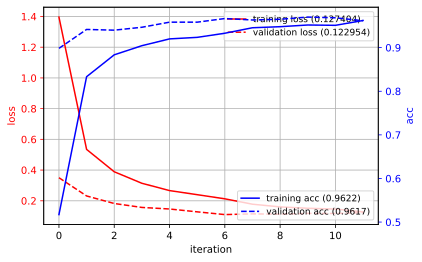

In [21]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Effects of Dropout
- dropping a node means the node's output is 0
  - i.e., the gradient is 0, which blocks some paths when computing gradients.
  - helps with vanishing gradient problem
- model averaging reduces the error.
- Dropout *reduces* the effective capacity of the network.
  - may need to increase the model size.
- At any  time  a node $h$ will be removed, i.e., that feature is missing.
  - then the other features must be sufficient to solve the classification problem
  - classifier doesn't depend exclusively on one feature.
  - increases classifier robustness.

# Data augmentation
- Problem: not enough data
- Solution: artificially permute the data to increase the dataset size
  - goal: make the network invariant to the permutations
  - examples: translate image, flip image, add pixel noise, rotate image, deform image, etc.
<center><img src="imgs/dogs.png" width=500></center>

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    data_format='channels_last')

# fit (required for some normalization augmentations)
datagen.fit(vtrainI)

In [23]:
img = vtrainI[0]
imgs = [img]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,28,28,1), [1], batch_size=1):
    imgs.append(augimg[0,:,:,0])
    cnt += 1
    if cnt > 8:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

- Example of original (top-left) and augmented data

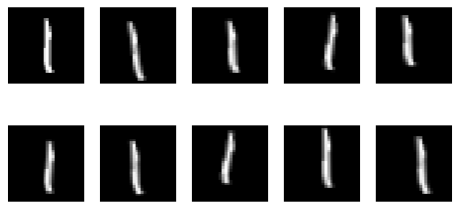

In [24]:
plt.figure(figsize=(8,4))
show_imgs(imgs, nc=5)

- Any transformation is okay, as long as the transformation doesn't confuse the classes.
  - e.g. don't rotate "6" so that it looks like a "9"
- Data augmentation improves robustness or invariance to selected transformations
  - encoded in the parameters of the model.

In [25]:
# initialize random seed
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', 
              input_shape=(28,28,1), padding='same'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu', padding='same'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu', padding='same'))
nn.add(Dropout(rate=0.5, seed=44))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dropout(rate=0.5, seed=45))
nn.add(Dense(units=10, activation='softmax'))

# compile the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])

- Train with `fit_generator`
  - passes data through the generator first (`datagen.flow(...)`)
  - runs generator and fit in parallel
- the dataset changes each epoch, so validation error will change a lot.
  - we disable early stopping and just let it run for 100 epochs.
- use TensorBoard to view the current results in real-time.
  - Create a `TensorBoard` object and use it as the callback.
  - This will write the history information to the logs directory.

In [26]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs/cnn1', histogram_freq=0,
                          write_graph=False, write_images=False)

# pass data through augmentor and fit
# runs data-generator and fit in parallel
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=300,
            callbacks=[tensorboard], 
            validation_data=validsetI, verbose=False)

/Users/abc/opt/anaconda3/envs/py38tflow2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


# Tensorboard
- Tensorboard runs as a local webserver to view the results in the log directory.
  - to start Tensorboard, run the following command in the shell: `tensorboard --logdir ./logs`
  - then connect to the local webserver using a browser (the URL is printed out when Tensorboard starts).

<center><img src="imgs/tensorboard.png" width=800></center>


- data augmentation increases accuracy.

test accuracy: 0.9917


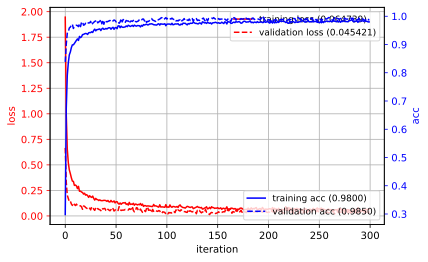

In [27]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Data augmentation with noise
- Also add per-pixel noise to the image for data augmentation.
  - define a function to add noise
  - set it as the `preprocessing_function`

In [28]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    preprocessing_function=add_gauss_noise, 
    data_format='channels_last'
)

# fit (required for some normalization augmentations)
datagen.fit(vtrainI)

- Example: original image (top-left) and augmented data

In [29]:
img = vtrainI[0]
imgs = [img]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,28,28,1), [1], batch_size=1):
    imgs.append(augimg[0,:,:,0])
    cnt += 1
    if cnt > 8:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

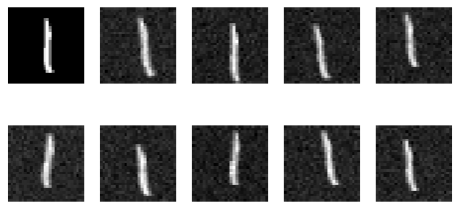

In [30]:
plt.figure(figsize=(8,4))
show_imgs(imgs, nc=5)

- Train with augmented data: transformations and per-pixel noise

In [31]:
# initialize random seed
random.seed(4487); tf.random.set_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', 
              input_shape=(28,28,1), padding='same'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu', padding='same'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu', padding='same'))
nn.add(Dropout(rate=0.5, seed=44))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dropout(rate=0.5, seed=45))
nn.add(Dense(units=10, activation='softmax'))

# compile the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='./logs/cnn2', histogram_freq=0,
                          write_graph=False, write_images=False)

# pass data through augmentor and fit
# runs data-generator and fit in parallel
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=300,
            callbacks=[tensorboard],
            validation_data=validsetI, verbose=False)

/Users/abc/opt/anaconda3/envs/py38tflow2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


- Similar results.

test accuracy: 0.9908


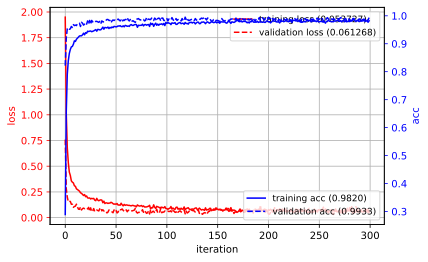

In [32]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Data generator options
- Sometimes the dataset is too large to store completely in RAM:
  - `datagen.flow_from_directory()` - iterate over images in a directory
  - `datagen.flow_from_dataframe()` - same, but use a pandas dataframe as the metadata.


# Comparison on MNIST
- For image data, CNN works better and has less parameters.
<table style="font-size:10pt;">
<tr>
  <th>Type</th>
  <th>No.Layers</th>
  <th>Architecture</th>
  <th>No.Parameters</th>
  <th>Test Accuracy</th>
</tr><tr>
  <td>LR</td>
  <td>1</td>
  <td>output(10)</td>
  <td>7,850</td>
  <td>0.8905</td>
</tr><tr>
  <td>MLP</td>
  <td>2</td>
  <td>ReLu(50), output(10)</td>
  <td>39,760</td>
  <td>0.9382</td>
</tr><tr>
  <td>MLP</td>
  <td>2</td>
  <td>Relu(200), output(10)</td>
  <td>159,010</td>
  <td>0.9448</td>
</tr><tr>
  <td>MLP</td>
  <td>2</td>
  <td>Relu(1000), output(10)</td>
  <td>795,010</td>
  <td>0.9480</td>
</tr><tr>
  <td>MLP</td>
  <td>3</td>
  <td>ReLu(500), Relu(500), output(10)</td>
  <td>648,010</td>
  <td>0.9499</td>
</tr><tr>
  <td>CNN</td>
  <td>3</td>
  <td>Conv(10x5x5), ReLu(50), output(10)</td>
  <td>98,820</td>
  <td>0.9487</td>
</tr><tr>
  <td>CNN</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>286,940</td>
  <td>0.9667</td>
</tr><tr>
  <td>CNN (w/ weight decay)</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>286,940</td>
  <td>0.9664</td>
</tr><tr>
  <td>CNN (ensemble)</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>5x286,940</td>
  <td>0.9706</td>
</tr><tr>
  <td>CNN (w/ dropout)</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>286,940</td>
  <td>0.9684</td>
</tr><tr>
  <td>CNN (w/ dropout, data-augmentation)</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>286,940</td>
  <td>0.9917</td>
</tr><tr>
  <td>CNN (w/ dropout, data-augmentation, noise)</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>286,940</td>
  <td>0.9908</td>
</tr>
</table>

# Summary
- **Convolutional neural network (CNN)**
  - convolution filters for extracting local image features
     - global translation equivariance 
  - local translation invariance using max-pooling
  - classifier using MLP on the image features.
- **Regularization methods**
  - L2-norm regularization (weight-decay) - keep weights from becoming too large
  - Early-stopping - adaptively keep weights from becoming too large
  - Ensembles - reduce error by bagging
  - Dropout  - approximate an ensemble of networks
  - Data Augmentation - make the NN robust to various image transformations